# Step1 - Import Libraries


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
import time

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题



# Step2 - Load Video & Extract Frames


视频路径: Video/Wingsuit.mp4
文件大小: 1.43 MB
尺寸: 640x360
总帧数: 92
FPS: 9.00000090000009
时长: 10.22 秒 (0.17 分钟)
Codec (FOURCC):    
提取的帧数: 90


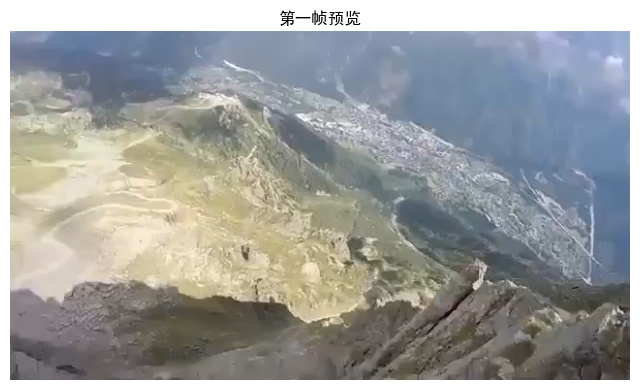

In [22]:
video_path = 'Video/Wingsuit.mp4'
max_extract_frames = 90

# 文件大小（MB）
file_size_mb = os.path.getsize(video_path) / (1024 * 1024)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f'无法打开视频：{video_path}')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0 or np.isnan(fps):
    fps = 30.0  # 默认值

duration_sec = total_frames / fps if fps > 0 else 0

# 解析 FOURCC
fourcc_int = int(cap.get(cv2.CAP_PROP_FOURCC))
# 将整数分解为 4 个字符
fourcc_chars = "".join([chr((fourcc_int >> 8 * i) & 0xFF) for i in range(4)])

print(f"视频路径: {video_path}")
print(f"文件大小: {file_size_mb:.2f} MB")
print(f"尺寸: {width}x{height}")
print(f"总帧数: {total_frames}")
print(f"FPS: {fps}")
print(f"时长: {duration_sec:.2f} 秒 ({duration_sec/60:.2f} 分钟)")
print(f"Codec (FOURCC): {fourcc_chars}")

# 提取帧
color_frames = []
gray_frames = []
frame_count = 0
start_time = time.time()
while frame_count < min(max_extract_frames, total_frames):
    ret, frame = cap.read()
    if not ret:
        break
    color_frames.append(frame.copy())
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frames.append(gray)
    frame_count += 1

cap.release()
print(f"提取的帧数: {len(color_frames)}")

# 显示第一帧（BGR -> RGB）
if len(color_frames) > 0:
    first_rgb = cv2.cvtColor(color_frames[0], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 5))
    plt.imshow(first_rgb)
    plt.axis('off')
    plt.title('第一帧预览')
    plt.show()



# Step3 - Dynamic Motion Tracking with Optical Flow


In [23]:
# 参数设置
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=10,
    blockSize=15
)
lk_params = dict(
    winSize=(25, 25),
    maxLevel=5,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

In [24]:
refresh_interval = 5  # 每 5 帧尝试刷新特征
min_valid_features = 50  # 最少有效特征数

p0 = cv2.goodFeaturesToTrack(gray_frames[0], mask=None, **feature_params)
if p0 is None:
    p0 = np.empty((0, 1, 2), dtype=np.float32)

# 帧迭代，跟踪并绘制箭头
annotated_frames = []
# mask 用于在每一帧上绘制轨迹（可选）
for i in range(1, len(gray_frames)):
    old_gray = gray_frames[i - 1]
    frame_gray = gray_frames[i]
    frame_bgr = color_frames[i].copy()

    if p0 is not None and len(p0) > 0:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # 如果没有找到任何点，初始化为空数组
        if p1 is None:
            p0 = np.empty((0, 1, 2), dtype=np.float32)
            st = np.empty((0, 1), dtype=np.uint8)
        else:
            good_new = p1[st == 1]
            good_old = p0[st == 1]
    else:
        good_new = np.empty((0, 2), dtype=np.float32)
        good_old = np.empty((0, 2), dtype=np.float32)

    # 如果有效特征过少或者到达刷新间隔，则检测新特征并合并
    if (len(good_new) < min_valid_features) or (i % refresh_interval == 0):
        # 在当前帧上检测新特征
        new_pts = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
        if new_pts is None:
            new_pts = np.empty((0, 1, 2), dtype=np.float32)
        # 将 new_pts 转为 (N,2) 并合并已有的 good_new
        if new_pts.size > 0:
            new_pts2 = new_pts.reshape(-1, 2)
            # 合并并限制到 maxCorners
            if good_new.size > 0:
                combined = np.vstack((good_new, new_pts2))
            else:
                combined = new_pts2
            # 只保留最多 200 个
            combined = combined[:feature_params['maxCorners']]
            good_new = combined
            # 对应 old 点：对新检测的点，我们将 old 设为相同位置（即速度0起始）
            good_old = good_new.copy()

    # 根据速度绘制箭头
    speeds = np.linalg.norm(good_new - good_old, axis=1) if good_new.size > 0 else np.array([])
    for (new_pt, old_pt, spd) in zip(good_new, good_old, speeds):
        x_new, y_new = int(new_pt[0]), int(new_pt[1])
        x_old, y_old = int(old_pt[0]), int(old_pt[1])
        # 速度着色规则 (BGR)
        if spd < 5:
            color = (255, 0, 0)  # 蓝
        elif spd < 15:
            color = (0, 255, 0)  # 绿
        else:
            color = (0, 0, 255)  # 红
        cv2.arrowedLine(frame_bgr, (x_old, y_old), (x_new, y_new), color, thickness=2, tipLength=0.3)

    annotated_frames.append(frame_bgr)

    # 更新 p0 为当前 good_new 以继续跟踪（reshape 回形状 (N,1,2)）
    if good_new.size > 0:
        p0 = good_new.reshape(-1, 1, 2).astype(np.float32)
    else:
        p0 = np.empty((0, 1, 2), dtype=np.float32)

print(f"生成标注帧数量：{len(annotated_frames)}")


生成标注帧数量：89


# Step4 - Generate & Display Animation

动画已保存到 Video/Wingsuit_Analysis.mp4


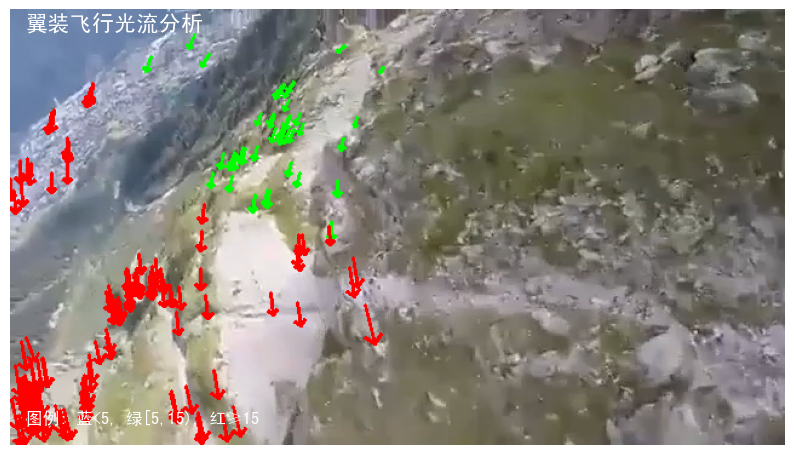

In [25]:
# 增加内嵌动画的大小限制（设置为 50MB）
plt.rcParams['animation.embed_limit'] = 50

# 创建画布和图像对象
fig, ax = plt.subplots(figsize=(10, 6))
# BGR to RGB for correct color in matplotlib
im = ax.imshow(cv2.cvtColor(annotated_frames[0], cv2.COLOR_BGR2RGB))
ax.axis('off')

# 添加图例和标题
ax.text(0.02, 0.95, "翼装飞行光流分析", transform=ax.transAxes, color="white", fontsize=16, weight='bold')
ax.text(0.02, 0.05, "图例: 蓝<5, 绿[5,15), 红≥15", transform=ax.transAxes, color="white", fontsize=12)

# 更新函数
def update(frame_index):
    # BGR to RGB for correct color in matplotlib
    im.set_array(cv2.cvtColor(annotated_frames[frame_index], cv2.COLOR_BGR2RGB))
    return [im]

# 创建动画
interval = 1000.0 / fps
anim = animation.FuncAnimation(fig, update, frames=len(annotated_frames), interval=interval, blit=True, repeat=True)

# 保存为 mp4
output_path = 'Video/Wingsuit_Analysis.mp4'
writer = animation.FFMpegWriter(fps=fps, codec='libx264')
anim.save(output_path, writer=writer)
print(f"动画已保存到 {output_path}")

# 在 Jupyter Notebook 中显示动画
HTML(anim.to_html5_video())

*"The video footage is sourced from the YouTube video 'GoPro: Graham Dickinson's Insane Wingsuit Flight - Front Helmet Cam 2 of 3' (URL: https://www.youtube.com/watch?v=kTzwvyzzfjk). This material is used for educational purposes only, with no copyright infringement intended."*  

# 学习心得：翼装飞行视频光流运动分析

本次项目通过 Python 和 OpenCV 对翼装飞行视频进行了光流运动分析，收获如下：

## 主要流程

1. **视频帧提取**  
   首先读取本地翼装飞行视频，提取前 90 帧并分别保存为彩色和灰度图像，为后续处理做准备。

2. **特征点检测与光流跟踪**  
   利用 `cv2.goodFeaturesToTrack` 检测角点，并用 Lucas-Kanade 光流算法跟踪这些特征点，实现了跨帧的动态运动追踪。

3. **速度计算与可视化**  
   通过计算特征点在两帧间的欧氏距离，获得运动速度，并用不同颜色的箭头（蓝、绿、红）在视频帧上进行速度分级可视化，直观展示了运动快慢和方向。

4. **动画生成与展示**  
   使用 Matplotlib 动画模块将标注后的帧合成为动态视频，并保存为 mp4，同时支持在 Jupyter Notebook 中直接播放，方便演示和分析。

# 挑战与收获
1. **挑战：**
* 1.在生成内嵌动画时遇到动画大小报错。
* 2.保存mp4时报错。
2. **解决：**
* 1.设置 Matplotlib 的参数，提升内嵌动画的大小限制。
* 2.conda删除功能不完整的ffmpeg，从gyan.dev下载ffmpeg

3. **收获:**
- 熟悉了视频处理和光流算法的实际应用流程。
- 掌握了特征点检测、运动跟踪和速度可视化的编程方法。
- 体会到数据可视化在运动分析中的直观优势。
- 通过不断刷新特征点，解决了特征点丢失和跟踪失败的问题，提高了分析的稳定性。

本项目不仅提升了我对计算机视觉基础的理解，也增强了实际动手能力，为后续更复杂的视频分析任务打下了坚实基础。